In [66]:
from pyquery import PyQuery as pq
import requests
from tqdm import tqdm_notebook
from tqdm import tqdm_notebook as tqdm
from pyelasticsearch import ElasticSearch
import pandas as pd
from datetime import datetime, timedelta
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from time import sleep
from matplotlib import animation
from matplotlib import gridspec
from IPython.display import HTML
import json
import numpy as np

Подобрать 10 дропов:
- Dock
- Gifto
- Viuly
- Refereum

- VinChain?

In [2]:
client = ElasticSearch("http://localhost:9201")

In [31]:
airdrops = requests.get("https://airdropalert.com/api/airdrops/list/past").json()

In [52]:
[a for a in airdrops if a['name'] == 'Dock'][0]["contract_address"] = "0xe5dada80aa6477e85d09747f2842f7993d0df71c"

In [42]:
for a in airdrops:
    if a["start_date"]:
        a["start_time"] = datetime.strptime(a['start_date']['date'].split(".")[0], "%Y-%m-%d %H:%M:%S")

In [43]:
deadline_date = datetime(2018, 6, 1)

In [44]:
airdrops = [a for a in airdrops if ("start_time" in a) and (a["start_time"] < deadline_date)]

In [45]:
def find_contract(contract_name):
    document = pq("https://etherscan.io/searchHandler?term=" + contract_name)
    return document.text()

In [46]:
def clean_contract(name):
    return name.replace("Exclusive Airdrop", "").strip()

In [47]:
def get_contract_address(string):
    array = string.split("\\t")
    if len(array) > 1:
        return array[1]

In [ ]:
for a in tqdm_notebook(airdrops):
    a["contract_address"] = get_contract_address(find_contract(clean_contract(a["name"])))

In [82]:
for a in tqdm_notebook(airdrops):
    if ("contract_address" in a) and (a["contract_address"]):
        count = client.count(index="ethereum-internal-transaction", doc_type="itx", query="to:" + a["contract_address"])['count']
        a["transactions_count"] = count
    else:
        a["transactions_count"] = 0

In [83]:
sorted_airdrops = sorted(airdrops, key=lambda x: -x["transactions_count"])

In [85]:
# wrong_airdrops = ["300cubits Exclusive Airdrop", "REDi", "Shivom Exclusive Airdrop", "TRON", "mCoin"]
wrong_airdrops = []

In [86]:
{a["name"]: (a["contract_address"], a["transactions_count"]) for a in sorted_airdrops[0:20] if a["name"] not in wrong_airdrops}

{'CFun': ('0x4b317864a05c91225ab8f401ec7be0aeb87e9c12', 112013),
 'ChronoBank': ('0x6531f133e6deebe7f2dce5a0441aa7ef330b4e53', 135033),
 'CryptoCarbon': ('0xe4c94d45f7aef7018a5d66f44af780ec6023378e', 115260),
 'Dock': ('0xe5dada80aa6477e85d09747f2842f7993d0df71c', 126847),
 'Gifto': ('0xc5bbae50781be1669306b9e001eff57a2957b09d', 315515),
 'Intelligent Commerce Chain': ('0xedc502b12ced7e16ce21749e7161f9ed22bfca53',
  145047),
 'Litex': ('0xbc46d9961a3932f7d6b64abfdec80c1816c4b835', 136135),
 'OSChain': ('0xfb5a551374b656c6e39787b1d3a03feab7f3a98e', 215504),
 'PolicyPal': ('0xfedae5642668f8636a11987ff386bfd215f942ee', 99152),
 'R_Block': ('0xb98d4c97425d9908e66e53a6fdf673acca0be986', 91300),
 'Realchain': ('0x13f25cd52b21650caa8225c9942337d914c9b030', 184731),
 'Refereum': ('0xd0929d411954c47438dc1d871dd6081f5c5e149c', 352829),
 'TIM': ('0x943ed852dadb5c3938ecdc6883718df8142de4c8', 171777),
 'Titanium': ('0xc7579bb99af590ec71c316e1ac4436c535039594', 120855),
 'Ubcoin': ('0x2d3e7d4870a51b

Для дропа:
- Найти блок начала и завершения
- Найти начальный адрес дропа (адрес с максимальным количеством транзакций)
- Пометить адреса, которые отправляют токенов сверх отправленных во время дропа

In [622]:
TOKEN = "0x519475b31653e46d20cd09f9fdcf3b12bdacb4f5"
BLOCK_GAP = 10000
NUMBER_OF_JOBS = 1000

In [665]:
airdrop = [a for a in airdrops if "Viuly" in a['name']][0]

In [666]:
start_date = airdrop["start_time"]

In [667]:
query = {
    "size": 1,
    "sort": [
        {"timestamp" : "desc"},
    ],
    "query": {
        "range": {
            "timestamp": {
                "lte": start_date
            }
        }
    }
}
start_block = client.send_request("GET", ["ethereum-block", "b", "_search"], query, {})['hits']['hits'][0]["_source"]["number"]

In [624]:
  def _count_by_object_or_string_query(client, query, index, doc_type):
    """
    Count objects in ElasticSearch by specified query

    Parameters
    ----------
    query : dict or str
        ElasticSearch query
    index : str
        ElasticSearch index
    doc_type : str
        Document type

    Returns
    -------
    int
        Number of objects in ElasticSearch
    """
    count_body = ''
    count_parameters = {}
    if type(query) is str:
      count_parameters['q'] = query
    else:
      count_body = {
        'query': query
      }
    return client.send_request('GET', [index, doc_type, '_count'], count_body, count_parameters)

  def iterate(client, index, doc_type, query, per=NUMBER_OF_JOBS):
    """
    Iterate through elasticsearch records

    Will return a chunk of records each time

    Parameters
    ----------
    index : str
        ElasticSearch index
    doc_type : str
        Document type
    query : dict or str
        ElasticSearch query
    per : int
        Max length of chunk

    Returns
    -------
    generator
        Generator that returns chunks with records by specified query
    """
    items_count = _count_by_object_or_string_query(client, query, index=index, doc_type=doc_type)['count']
    pages = round(items_count / per + 0.4999)
    scroll_id = None
    for page in tqdm(range(pages)):
      if not scroll_id:
        pagination_parameters = {'scroll': '60m', 'size': per}
        pagination_body = {}
        if type(query) is str:
          pagination_parameters['q'] = query
        else:
          pagination_body['query'] = query
        response = client.send_request('GET', [index, doc_type, '_search'], pagination_body, pagination_parameters)
        scroll_id = response['_scroll_id']
        page_items = response['hits']['hits']
      else:
        page_items = client.send_request('POST', ['_search', 'scroll'], {'scroll': '60m', 'scroll_id': scroll_id}, {})['hits']['hits']
      yield page_items

In [625]:
query = {
    "bool": {
        "must": [
            {"term": {"token.keyword": TOKEN}},
        ]
    }
}

transactions = []
for t in iterate(client, index="ethereum-token-transaction", doc_type="tx", query=query):
    transactions += t

In [626]:
transactions_df = pd.DataFrame([t["_source"] for t in transactions])

In [627]:
transactions_df.shape[0]

998597

In [628]:
transactions_df.to_csv("viuly_airdrop.csv")

In [60]:
transactions_df = pd.read_csv("viuly_airdrop.csv")

In [629]:
token_prices = client.search(index="ethereum-token-price", doc_type="price", size=2000, query="token:VIU AND USD:[0.0001 TO *]")["hits"]["hits"]
token_prices = [t["_source"] for t in token_prices]

In [630]:
prices_df = pd.DataFrame()

In [631]:
prices_df["USD"] = [t["USD"] for t in token_prices]

In [632]:
prices_df["timestamp"] = [t["timestamp"] for t in token_prices]

In [633]:
def get_block_by_timestamp(timestamp):
    timestamp = datetime.strptime(timestamp, "%Y-%m-%d")
    query = {
        "size": 1,
        "sort": [
            {"timestamp" : "desc"},
        ],
        "query": {
            "range": {
                "timestamp": {
                    "lte": timestamp
                }
            }
        }
    }
    return client.send_request("GET", ["ethereum-block", "b", "_search"], query, {})['hits']['hits'][0]["_source"]["number"]

In [634]:
prices_df["block"] = prices_df["timestamp"].apply(get_block_by_timestamp)

In [635]:
prices_df.to_csv("viuly_prices.csv")

In [636]:
prices_df = pd.read_csv("viuly_prices.csv")

In [107]:
addresses_types_df = pd.read_csv("addresses_types.csv").set_index("address")

Скользящим окном визуализируем граф:
- Получаем скользящее окно
- Составляем граф
- Находим компоненту связности с drop_address внутри
- Визуализируем ее

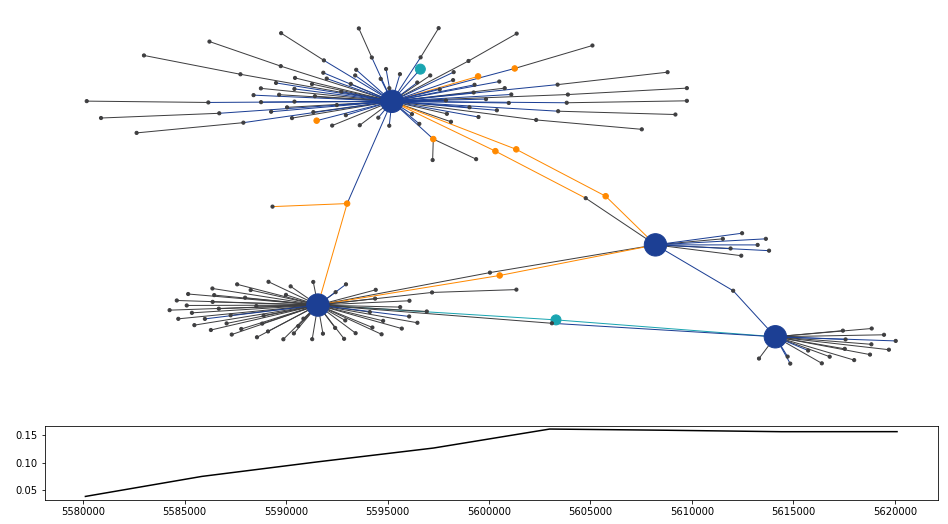

In [18]:
TRANSACTIONS_IN_GRAPH = 500
FRAMES = 20
START_POINT = int(66000 / TRANSACTIONS_IN_GRAPH)

fig = plt.figure(figsize=(16, 9))

# Get a place for new vertices
# Draw vertices
# Draw edges

old_layout = None
progress_bar = tqdm_notebook(total=FRAMES)

colors = {
    "cex": "#1c3f94",
    "drop": "#f15a22",
    "trader": "#1aa5b1",
    "investor": "#ff8900",
    "holder": "#3e3e40"
}

sizes = {
    "cex": 500,
    "drop": 500,
    "trader": 100,
    "investor": 30,
    "holder": 10
}

def update(i):
    global old_layout
    global progress_bar
    progress_bar.update(1)
    window_range = range(START_POINT*TRANSACTIONS_IN_GRAPH, (i + 1 + START_POINT)*TRANSACTIONS_IN_GRAPH)
    plt.title("Epoch: {}".format(i))
    window = transactions_df.sort_values("block_id").iloc[window_range]
    addresses_types_df = get_types(window)
    max_block = window["block_id"].max()
    prices = prices_df[prices_df["block"] < max_block].sort_values("block")
    graph = create_graph(window)
    try:
        if old_layout:
            old_layout = nx.spring_layout(graph, pos=old_layout, fixed=old_layout.keys(), iterations=1000)
        else:
            old_layout = nx.spring_layout(graph)
    except:
        old_layout = nx.spring_layout(graph)
    node_color = [colors[t] for t in addresses_types_df.loc[[n for n in graph]]["type"]]
    node_size = [sizes[t] for t in addresses_types_df.loc[[n for n in graph]]["type"]]
    edge_color = [colors[t] for t in addresses_types_df.loc[[a for a, b in graph.edges]]["type"]]
    gs = gridspec.GridSpec(2, 1, height_ratios=[5, 1]) 
    plt.subplot(gs[0])
    nx.draw(graph, pos=old_layout, node_color=node_color, node_size=node_size, edge_color=edge_color)
    plt.subplot(gs[1])
    plt.plot(prices["block"], prices["USD"], color="#000000")
    
ani = animation.FuncAnimation(fig, update, frames=FRAMES, interval=500)
# HTML(ani.to_html5_video())
ani.save('dockdrop1.gif', dpi=80, writer='imagemagick')

Типы вершин
- Холдер (меньше двух исходящих транзакций)
- Трейдер (много входящих и исходящих к биржам), влияет на количество транзакций от биржи
- Распределение (много исходящих, в 10 больше, чем входящих)
- Биржа (найдем по именам)
- Инвестор (прочие)

## Биржи

In [67]:
def find_name(address):
    document = pq("https://etherscan.io/address/{}".format(address))
    return document("font[title='NameTag']").text()

In [68]:
top_to_addresses = transactions_df[["to", "value"]].groupby("to").sum().sort_values("value", ascending=0).head(500)

In [69]:
top_from_addresses = transactions_df[["from", "value"]].groupby("from").sum().sort_values("value", ascending=0).head(500)

In [70]:
top_addresses = set(list(top_to_addresses.index) + list(top_from_addresses.index))

In [71]:
names = []

In [72]:
for address in tqdm_notebook(list(top_addresses)):
    names.append(find_name(address))

In [73]:
top_addresses_df = pd.DataFrame()
top_addresses_df["address"] = list(top_addresses)
top_addresses_df["name"] = names

In [74]:
top_addresses_df["name"].unique()

array(['', 'Fake_Phishing316', 'Okex_1', 'EtherDelta_2',
       'Fake_Phishing622', 'IDEX_1'], dtype=object)

In [75]:
cexs = ["Binance", "Kucoin", "Gate.io", "IDEX", "Coinbene", "EtherDelta", "Bancor", "Okex", "Kryptono", "Bibox", "Cobinhood"]

In [76]:
cex_addresses = list(top_addresses_df[top_addresses_df["name"].apply(lambda x: any([b in x for b in cexs]))]["address"])

In [77]:
cex_addresses

['0x6cc5f688a315f3dc28a7781717a9a798a59fda7b',
 '0x8d12a197cb00d4747a1fe03395095ce2a5cc6819',
 '0x2a0c0dbecc7e4d658f48e01e3fa353f44050c208']

In [483]:
cex_addresses

['0x9539e0b14021a43cde41d9d45dc34969be9c7cb0',
 '0xfe9e8709d3215310075d67e3ed32a380ccf451c8',
 '0xd551234ae421e3bcba99a0da6d736074f22192ff',
 '0x3f5ce5fbfe3e9af3971dd833d26ba9b5c936f0be',
 '0x2a0c0dbecc7e4d658f48e01e3fa353f44050c208',
 '0x564286362092d8e7936f0549571a803b203aaced',
 '0x1c4b70a3968436b9a0a9cf5205c787eb81bb558c',
 '0x8d12a197cb00d4747a1fe03395095ce2a5cc6819',
 '0x0d0707963952f2fba59dd06f2b425ace40b492fe',
 '0x0681d8db095565fe8a346fa0277bffde9c0edbbf',
 '0x2b5634c42055806a59e9107ed44d43c426e58258']

## Холдеры

In [412]:
inactive_addresses = transactions_df[["from", "value"]].groupby("from").count().sort_values("value")

In [413]:
holders = inactive_addresses[inactive_addresses["value"] <= 1].index

In [414]:
all_from_addresses = list(inactive_addresses.index)
all_to_addresses = list(transactions_df["to"].unique())
no_out_transactions_addresses = [a for a in tqdm_notebook(all_to_addresses) if a not in all_from_addresses]

KeyboardInterrupt: 

In [137]:
holders = no_out_transactions_addresses + list(holders)

## Адреса Airdrop

## Трейдеры

Можно отличить по количеству транзакций к и от бирж

In [147]:
cex_transactions_df = transactions_df[transactions_df.apply(lambda x: (x["from"] in cex_addresses) or (x["to"] in cex_addresses), axis=1)]

In [148]:
from_addresses = cex_transactions_df[["from", "value"]].groupby("from").count()
from_addresses["value1"] = from_addresses["value"]
to_addresses = cex_transactions_df[["to", "value"]].groupby("to").count()
to_addresses["value2"] = to_addresses["value"]

In [149]:
traders_df = pd.concat([from_addresses[["value1"]], to_addresses[["value2"]]], axis=1, sort=False).fillna(0)

In [152]:
traders_df["ratio"] = traders_df["value1"] / traders_df["value2"]

In [153]:
traders_df = traders_df[(traders_df["ratio"] > 0.9) & (traders_df["ratio"] < 1.1)]

In [162]:
traders = list(traders_df.index)

# Все типы

In [250]:
all_addresses = set(list(transactions_df["from"].unique()) + list(transactions_df["to"].unique()))

In [251]:
addresses_types_df = pd.DataFrame()
addresses_types_df["address"] = list(all_addresses)

In [252]:
cex_addresses = set(cex_addresses)
drop_addresses = set(drop_addresses)
traders = set(traders)
holders = set(holders)

In [253]:
def detect_type(address):
    if address in cex_addresses:
        return "cex"
    elif address in drop_addresses:
        return "drop"
    elif address in traders:
        return "trader"
    elif address in holders:
        return "holder"
    else:
        return "investor"

In [254]:
addresses_types_df["type"] = addresses_types_df["address"].apply(detect_type)

In [255]:
addresses_types_df["type"].value_counts()

holder      48991
investor     3420
trader       1613
cex            11
drop            6
Name: type, dtype: int64

In [256]:
addresses_types_df = addresses_types_df.set_index("address")

In [169]:
addresses_types_df.to_csv("addresses_types.csv")

## Записать граф в БД

In [556]:
users = ["FundRequest", "SocialX"]

In [557]:
users_addresses = [a for u in users for a in find_contract(u).split("\\t") if a.startswith("0x")]

In [648]:
drop_addresses = transactions_df.groupby("from").count()["to"].sort_values(ascending=False).head(20)

In [78]:
out_transactions_number = [transactions_df[transactions_df["to"] == a].shape[0] for a in tqdm_notebook(drop_addresses.index)]

TypeError: 'builtin_function_or_method' object is not iterable

In [ ]:
drop_addresses_df = pd.DataFrame()
drop_addresses_df["addresses"] = drop_addresses.index
drop_addresses_df["out"] = list(drop_addresses)
drop_addresses_df["in"] = out_transactions_number

In [ ]:
drop_addresses_df["distribution"] = drop_addresses_df.apply(lambda x: x["out"] >= x["in"]*10, axis=1)

In [ ]:
drop_addresses = drop_addresses_df[drop_addresses_df["distribution"]]["addresses"]

In [ ]:
drop_addresses = list(drop_addresses)

In [127]:
# cex_addresses = ['0xa8ace92ea2d9174f75208ee44495f459e0491a96',
#  '0x0681d8db095565fe8a346fa0277bffde9c0edbbf',
#  '0x236f9f97e0e62388479bf9e5ba4889e46b0273c3',
#  '0x629a7144235259336ea2694167f3c8b856edd7dc',
#  '0x3f5ce5fbfe3e9af3971dd833d26ba9b5c936f0be',
#  '0xf73c3c65bde10bf26c2e1763104e609a41702efe',
#  '0xe8a0e282e6a3e8023465accd47fae39dd5db010b',
#  '0xd551234ae421e3bcba99a0da6d736074f22192ff',
#  '0xfe9e8709d3215310075d67e3ed32a380ccf451c8',
#  '0x6cc5f688a315f3dc28a7781717a9a798a59fda7b',
#  '0x564286362092d8e7936f0549571a803b203aaced',
#  '0x8d12a197cb00d4747a1fe03395095ce2a5cc6819',
#  '0xe88d6d63389d5c91e6348e379913f330739ad2c4']

In [103]:
def get_types(window):    
    # Find holders
    inactive_addresses = window[["from", "value"]].groupby("from").count().sort_values("value")
    holders = inactive_addresses[inactive_addresses["value"] <= 1].index
    all_from_addresses = list(inactive_addresses.index)
    all_to_addresses = list(window["to"].unique())
    no_out_transactions_addresses = [a for a in all_to_addresses if a not in all_from_addresses]
    holders = no_out_transactions_addresses + list(holders)
    
    # Find traders
    cex_transactions_df = window[window.apply(lambda x: (x["from"] in cex_addresses) or (x["to"] in cex_addresses), axis=1)]
    from_addresses = cex_transactions_df[["from", "value"]].groupby("from").count()
    from_addresses["value1"] = from_addresses["value"]
    to_addresses = cex_transactions_df[["to", "value"]].groupby("to").count()
    to_addresses["value2"] = to_addresses["value"]
    traders_df = pd.concat([from_addresses[["value1"]], to_addresses[["value2"]]], axis=1, sort=False).fillna(0)
    traders_df["ratio"] = traders_df["value1"] / traders_df["value2"]
    traders_df = traders_df[(traders_df["ratio"] > 0.8) & (traders_df["ratio"] < 1.2)]
    traders = list(traders_df.index)
    
#     # Find contracts
    all_addresses = list(set(list(window["from"].unique()) + list(window["to"].unique())))
    contracts = []
    for addresses in tqdm_notebook(np.array_split(all_addresses, int(len(all_addresses) / 900))):
        try:
            query = {
                "query": {
                    "terms": {
                        "address": list(addresses)
                    }
                }
            }
            result = client.search(index='ethereum-contract', doc_type="contract", query=query, size=1000)['hits']['hits']
            contracts += [r["_id"] for r in result]
        except:
            pass
    
    # Create DF with types
    addresses_types_df = pd.DataFrame()
    all_addresses = set(list(window["from"].unique()) + list(window["to"].unique()))
    addresses_types_df["address"] = list(all_addresses)
    addresses_types_df["type"] = "investor"
    addresses_types_df = addresses_types_df.set_index("address")
    addresses_types_df.loc[traders, "type"] = "trader"
    for address in drop_addresses:
        if address in addresses_types_df.index:
            addresses_types_df.loc[address, "type"] = "airdrop"
    addresses_types_df.loc[contracts, "type"] = "contract"
    addresses_types_df.loc[holders, "type"] = "holder"
    for address in cex_addresses:
        if address in addresses_types_df.index:
            addresses_types_df.loc[address, "type"] = "cex"
    return addresses_types_df

In [95]:
def get_balances(window):
    outcomes = window[["from", "value"]].groupby("from").sum()
    incomes = window[["to", "value"]].groupby("to").sum()
    balances = {}
    for address, row in incomes.iterrows():
        balances[address] = row["value"]
    for address, row in outcomes.iterrows():
        balances[address] = np.abs(balances.get(address, 0) - row["value"])
    return balances

In [96]:
def create_graph(window):
    drop_addresses = window[window["method"] == "transferFrom"].groupby("from").count()["to"].sort_values(ascending=False)
    G = nx.DiGraph()
    G.add_nodes_from(window["to"].unique())
    G.add_edges_from(set([(r["from"], r["to"]) for i, r in window.iterrows()]))
    return G

In [97]:
def reduce_components(G):
    components = sorted(nx.weakly_connected_component_subgraphs(G), key=lambda x: -len(x))
    graph = components[0]
    for component in components[1:]:
        if (len(component.nodes) > 0.5 * len(components[0].nodes)) and (len(component.nodes) > 5):
            graph = nx.compose(graph, component)
    return graph

In [98]:
transactions_df["block_id"].max()

6067253

In [99]:
def get_distance(x):
    if x < start_block:
        return (start_block - x) / BEFORE_BLOCK_GAP
    elif x > start_block:
        return (x - start_block) / AFTER_BLOCK_GAP
    else:
        return 0

In [100]:
transactions_df["time"] = transactions_df["block_id"].apply(get_distance)

In [87]:
BEFORE_BLOCK_GAP = 100000
AFTER_BLOCK_GAP = 1000000

In [88]:
start_block

5179745

In [89]:
new_transactions = transactions_df[(transactions_df["block_id"] > start_block - BEFORE_BLOCK_GAP) & (transactions_df["block_id"] < start_block + AFTER_BLOCK_GAP)]

In [90]:
new_transactions.shape

(8141, 15)

In [104]:
window = new_transactions.sort_values("block_id")
addresses_types_df = get_types(window)

In [105]:
graph = create_graph(window)

Serve only proxy nodes from airdrop node

In [106]:
degrees = list(sorted(dict(graph.degree).items(), key=lambda x: x[1]))
for node, degree in tqdm_notebook(degrees):
    out_nodes = list(graph.successors(node))
    in_nodes = list(graph.predecessors(node)) 
    if not len(out_nodes):
        graph.remove_node(node)
    if (len(out_nodes) == 1) and (len(in_nodes) == 1):
        out_node = out_nodes[0]
        in_node = in_nodes[0]
        if addresses_types_df.loc[in_node, "type"] == "airdrop":
            if graph.degree[out_node] == 0:
                graph.remove_node(node)
                graph.remove_node(out_node)
            else:
                graph.remove_node(node)            
                try:
                    if in_node not in graph.predecessors(out_node):
                        graph.add_edge(in_node, out_node)
                except:
                    print("Exception!", out_node)

In [107]:
graph = reduce_components(graph)

In [108]:
len(graph.nodes)

1502

In [125]:
addresses_types_df.loc["0x236f9f97e0e62388479bf9e5ba4889e46b0273c3", "type"] = "cex"

In [126]:
a = [{"address": n, "type": addresses_types_df["type"].loc[n]} for n in graph]

In [1]:
token_transactions_df["value"].sum()

NameError: name 'token_transactions_df' is not defined

In [127]:
def get_value(a, b):
    return token_transactions_df[(token_transactions_df["from"] == a) & (token_transactions_df["to"] == b)]["value"].sum()

In [128]:
t = [{"from": a, "to": b} for a, b in tqdm_notebook(graph.edges)]

In [129]:
airdrop_jsons = json.load(open("prepared_airdrops.json"))

In [130]:
prices = [a for a in airdrop_jsons if a["name"] == "Qtum "][0]["prices"]

In [134]:
airdrop_json = {
    "name": "Viuly",
    "image": "https://www.bitbetnews.com/wp-content/uploads/2018/03/shto_takoe_kriptovalyuta_viuly.jpg",
    "addresses": a,
    "transactions": t,
    "prices": prices
}

In [135]:
json.dump(airdrop_json, open("graph/airdrops/viuly_airdrop.json", "w"))

In [436]:
node_color = addresses_df["cluster"].to_dict()

In [439]:
colors = addresses_df["cluster"].to_dict()
[n for n in graph.nodes if n not in colors]

[]

- Как токен используется? Как можно найти тех, кто реально использует токен?
- Что дает ICO dock?

# Дропы vs ICO

In [512]:
drop_addresses = list(addresses_types_df[addresses_types_df["type"] == "airdrop"].index)

In [513]:
query = {
    "size": 0,
    "query": {
        "bool": {
            "must": [
                {"terms": {"to": drop_addresses}}
            ]
        }
    },
    "aggs": {
        "drops": {
            "terms": {
                "field": "to",
                "size": len(drop_addresses),
            },
            "aggs": {
                "income": {
                    "sum": {
                        "field": "value"
                    }
                },
                "incoming_addresses": {
                    "cardinality": {
                        "field": "from"
                    }
                }
            }
        }
    }
}

result = client.search(index="ethereum-internal-transaction", doc_type="itx", query=query)

In [515]:
result['aggregations']

{'drops': {'buckets': [{'doc_count': 45506,
    'income': {'value': 340235.44172850234},
    'incoming_addresses': {'value': 30117},
    'key': '0x30146933a3a0babc74ec0b3403bec69281ba5914'},
   {'doc_count': 171,
    'income': {'value': 339.9712186604738},
    'incoming_addresses': {'value': 103},
    'key': '0xb99adfb2679bfb78636900bec8df9793fa073841'},
   {'doc_count': 93,
    'income': {'value': 0.0},
    'incoming_addresses': {'value': 1},
    'key': '0xc7300057a24b495e08b4bd7b99694848b44d6204'},
   {'doc_count': 15,
    'income': {'value': 36.730258570984006},
    'incoming_addresses': {'value': 5},
    'key': '0x83b1638d7fe26b79bb0edb2cffd16428e7676244'},
   {'doc_count': 6,
    'income': {'value': 0.12175630300771445},
    'incoming_addresses': {'value': 5},
    'key': '0xae397137cd037fe6f45f7df5b49c845ef6402e58'}],
  'doc_count_error_upper_bound': 0,
  'sum_other_doc_count': 0}}

# Эффекты дропов

In [448]:
prices_df = pd.read_csv("_prices.csv")

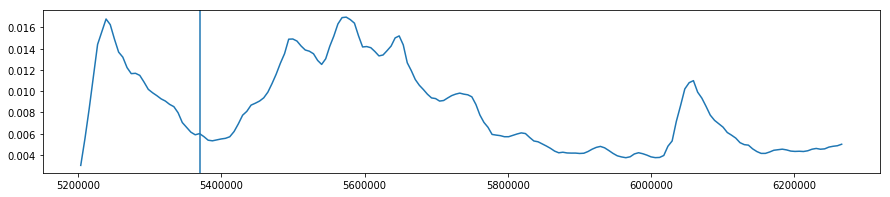

In [616]:
x = prices_df.sort_values("block")["block"]
y = prices_df.sort_values("block")["USD"]
plt.figure(figsize=(15, 3))
plt.plot(x, y)
plt.axvline(get_block_by_timestamp("2018-04-03"))
# plt.axvline(get_block_by_timestamp("2018-03-03"))

- Количество транзакций на биржу 
- Количество баунти хантеров
- Количество инвестиций на адреса crowdsale

- Бонусные баллы?

- Изменение курсов (до и после даты)
- Изменение размера комьюнити (до и после даты), на графике

# Визуализировать время

# Найти баунти хантеров и инвесторов

Баунти хантеры:
- Имеют большое количество токенов
- Имеют небольшую среднюю ETH транзакцию

Инвесторы:
- Отправляют ETH в ответ на дроп
- Участвуют в ICO

## Dock

In [3]:
drop_addresses = ["0xfc31cdbd39253fd43eb1776e446b33183d613dc9"]

In [5]:
cex_addresses

In [6]:
transactions_df = pd.read_csv("dock_airdrop.csv")

In [276]:
AFTER_BLOCK_GAP = 1000000
end_block = start_block + AFTER_BLOCK_GAP

In [277]:
transactions_df[(transactions_df["block_id"] > start_block) & (transactions_df["block_id"] < end_block) & (transactions_df["from"] == "0xfc31cdbd39253fd43eb1776e446b33183d613dc9")].shape

(40574, 11)

- Найти всех участников дропа
- Убрать биржи/дропы
- Кластеризовать по признакам (до дропа)
    - Средний вход eth
    - Средний выход eth
    - Количество имеющихся токенов на счете до дропа - (количество уникальных контрактов)
    - Количество и объем транзакций ICO (пока не трогать)
    - Количество обращений к контрактам (c ненулевым input)
    - Количество исходящих транзакций на биржи 
    - Количество входящих транзакций с бирж
- Агрегировать по кластерам
- Посмотреть, какие кластеры могут влиять на качество дропа

In [504]:
all_addresses = list(set(list(window["from"].unique()) + list(window["to"].unique())))

In [505]:
addresses_df = pd.DataFrame()
addresses_df["address"] = all_addresses
addresses_df = addresses_df.set_index('address')

In [506]:
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

In [510]:
def add_features(index, doc_type, query_lambda, key):
    result = []
    for addresses in tqdm_notebook(list(chunks(all_addresses, 100))):
        query = query_lambda(addresses, key)
        result.append(client.search(index=index, doc_type=doc_type, query=query))

    results = {b["key"]: b[key]["value"] for r in result for b in r["aggregations"]["drops"]["buckets"]}
    for address, value in tqdm_notebook(results.items()):
        addresses_df.loc[address, key] = value

In [515]:
def query(addresses, key):
    query = {
        "size": 0,
        "query": {
            "bool": {
                "must": [
                    {"terms": {"to": addresses}},
                    {"range": {"blockNumber": {"lte": start_block}}}
                ]
            }
        },
        "aggs": {
            "drops": {
                "terms": {
                    "field": "to",
                    "size": len(addresses),
                },
                "aggs": {
                    key: {
                        "avg": {
                            "field": "value"
                        }
                    }
                }
            }
        }
    }
    return query

add_features(index="ethereum-internal-transaction", doc_type="itx", query_lambda=avg_income_query, key="avg_income")

In [516]:
def query(addresses, key):
    query = {
        "size": 0,
        "query": {
            "bool": {
                "must": [
                    {"terms": {"from": addresses}},
                    {"range": {"blockNumber": {"lte": start_block}}}
                ]
            }
        },
        "aggs": {
            "drops": {
                "terms": {
                    "field": "from",
                    "size": len(addresses),
                },
                "aggs": {
                    key: {
                        "avg": {
                            "field": "value"
                        }
                    }
                }
            }
        }
    }
    return query

add_features(index="ethereum-internal-transaction", doc_type="itx", query_lambda=query, key="avg_outcome")

In [517]:
def query(addresses, key):
    query = {
        "size": 0,
        "query": {
            "bool": {
                "must": [
                    {"terms": {"to.keyword": addresses}},
                    {"term": {"token.keyword": TOKEN}},
                    {"range": {"block_id": {"lte": start_block}}}
                ]
            }
        },
        "aggs": {
            "drops": {
                "terms": {
                    "field": "to.keyword",
                    "size": len(addresses),
                },
                "aggs": {
                    key: {
                        "sum": {
                            "field": "value"
                        }
                    }
                }
            }
        }
    }
    return query

add_features(index="ethereum-token-transaction", doc_type="tx", query_lambda=query, key="token_income")

In [519]:
def query(addresses, key):
    query = {
        "size": 0,
        "query": {
            "bool": {
                "must": [
                    {"terms": {"from": addresses}},
                    {"query_string": {"query": "!(input:0x)"}},
                    {"range": {"block_id": {"lte": start_block}}}
                ]
            }
        },
        "aggs": {
            "drops": {
                "terms": {
                    "field": "from",
                    "size": len(addresses),
                },
                "aggs": {
                    key: {
                        "cardinality": {
                            "field": "to"
                        }
                    }
                }
            }
        }
    }
    return query

add_features(index="ethereum-internal-transaction", doc_type="itx", query_lambda=query, key="contract_transactions")

In [550]:
def query(addresses, key):
    query = {
        "size": 0,
        "query": {
            "bool": {
                "must": [
                    {"terms": {"from": addresses}},
                    {"terms": {"to": cex_addresses}},
                ]
            }
        },
        "aggs": {
            "drops": {
                "terms": {
                    "field": "from",
                    "size": len(addresses),
                },
                "aggs": {
                    key: {
                        "value_count": {
                            "field": "value"
                        }
                    }
                }
            }
        }
    }
    return query

add_features(index="ethereum-internal-transaction", doc_type="itx", query_lambda=query, key="exchange_transactions")

In [587]:
def query(addresses, key):
    query = {
        "size": 0,
        "query": {
            "bool": {
                "must": [
                    {"terms": {"to": addresses}},
                    {"terms": {"from": cex_addresses}},
                ]
            }
        },
        "aggs": {
            "drops": {
                "terms": {
                    "field": "to",
                    "size": len(addresses),
                },
                "aggs": {
                    key: {
                        "value_count": {
                            "field": "value"
                        }
                    }
                }
            }
        }
    }
    return query

add_features(index="ethereum-internal-transaction", doc_type="itx", query_lambda=query, key="out_exchange_transactions")

In [591]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [592]:
addresses_df.to_csv("addresses_stats1.csv")

In [613]:
addresses_df = pd.read_csv("addresses_stats1.csv").set_index("address")

In [597]:
for column in addresses_df.columns:
    addresses_df[column] = np.log(addresses_df[column].fillna(0) + 1 + 0.00001 * np.random.randn(addresses_df.shape[0]))

In [598]:
kmeans = KMeans(n_clusters=10)
clusters = kmeans.fit_predict(addresses_df)

In [615]:
addresses_df["cluster"] = clusters

In [600]:
pca = PCA(n_components=2)
pca_stats = pca.fit_transform(addresses_df)

In [601]:
from sklearn.manifold import TSNE
# pca_stats = TSNE(n_components=2, verbose=1).fit_transform(addresses_df)

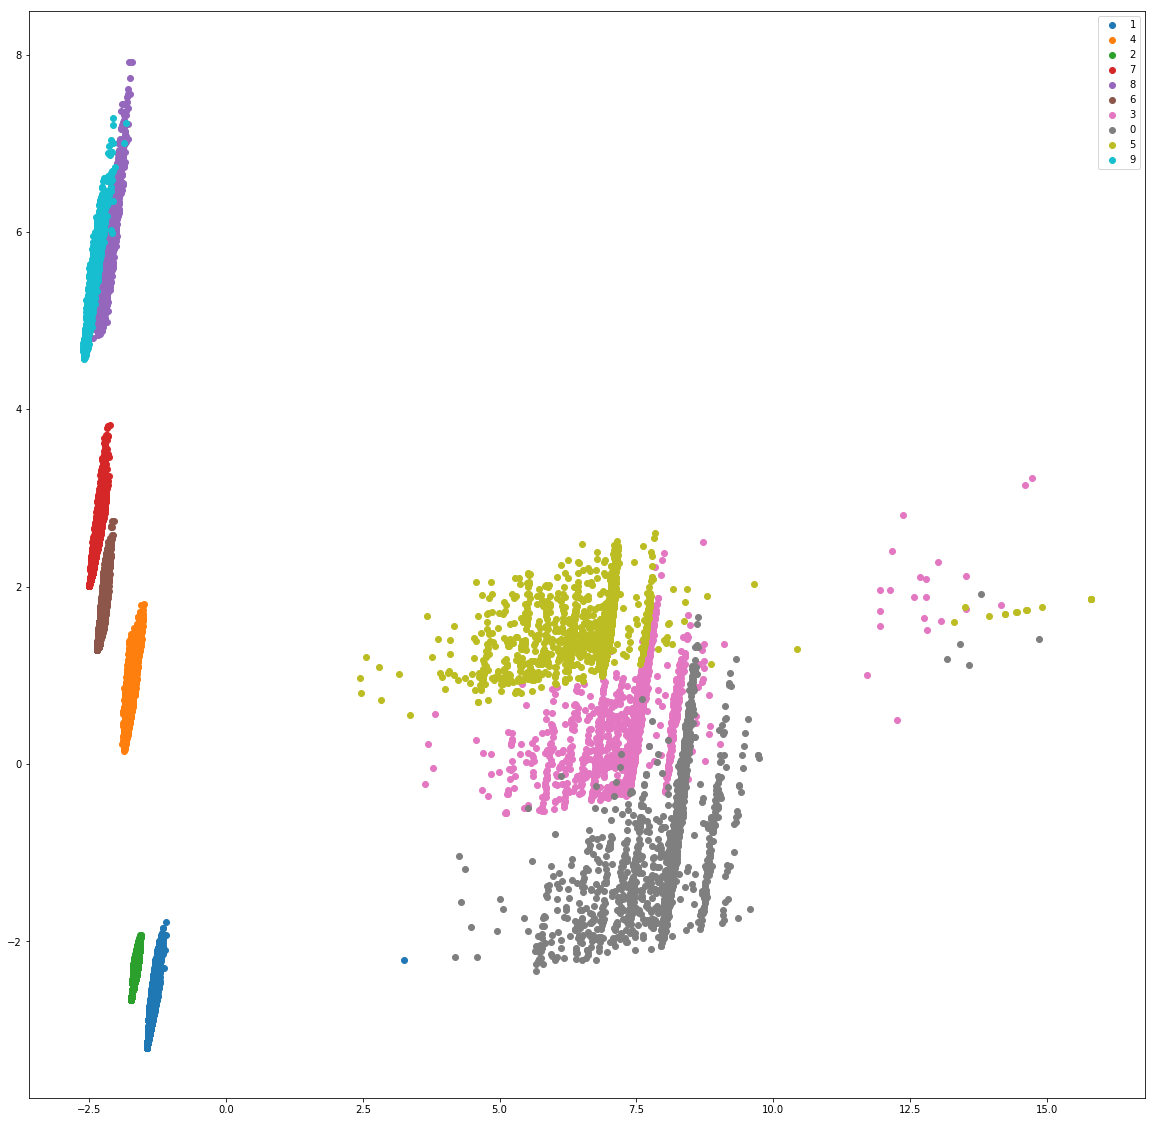

In [602]:
plt.figure(figsize=(20, 20))
for cluster in addresses_df["cluster"].unique():
    stats = pca_stats[addresses_df["cluster"] == cluster]
    plt.scatter(stats.transpose()[0], stats.transpose()[1], label=cluster)
plt.legend()

In [603]:
clusters = addresses_df["cluster"]

In [604]:
addresses_df["cluster"] = clusters

In [617]:
cleaned_addresses = addresses_df[~addresses_df.index.isin(cex_addresses + drop_addresses)]

In [618]:
cleaned_addresses.groupby("cluster").median()

,avg_income,avg_outcome,token_income,contract_transactions,exchange_transactions,out_exchange_transactions
cluster,,,,,,
0,1.522184,0.684226,10714.000000,17.0,26.5,16.0
1,0.611492,0.325489,107.139999,6.0,2.0,2.0
2,0.198234,0.138000,NaN,1.0,1.0,1.0
3,1.935696,1.093373,10714.000000,9.0,3.0,5.0
4,0.689281,0.319622,NaN,8.0,15.0,7.0
5,1.003000,0.998150,10714.000000,2.0,2.0,2.0
6,0.470000,0.423077,NaN,2.0,3.0,3.0
7,3.368182,2.233333,NaN,3.0,2.0,2.0
8,1.484388,0.488792,NaN,25.0,79.0,26.0


In [619]:
cleaned_addresses.groupby("cluster").median()

,avg_income,avg_outcome,token_income,contract_transactions,exchange_transactions,out_exchange_transactions
cluster,,,,,,
0,1.522184,0.684226,10714.000000,17.0,26.5,16.0
1,0.611492,0.325489,107.139999,6.0,2.0,2.0
2,0.198234,0.138000,NaN,1.0,1.0,1.0
3,1.935696,1.093373,10714.000000,9.0,3.0,5.0
4,0.689281,0.319622,NaN,8.0,15.0,7.0
5,1.003000,0.998150,10714.000000,2.0,2.0,2.0
6,0.470000,0.423077,NaN,2.0,3.0,3.0
7,3.368182,2.233333,NaN,3.0,2.0,2.0
8,1.484388,0.488792,NaN,25.0,79.0,26.0


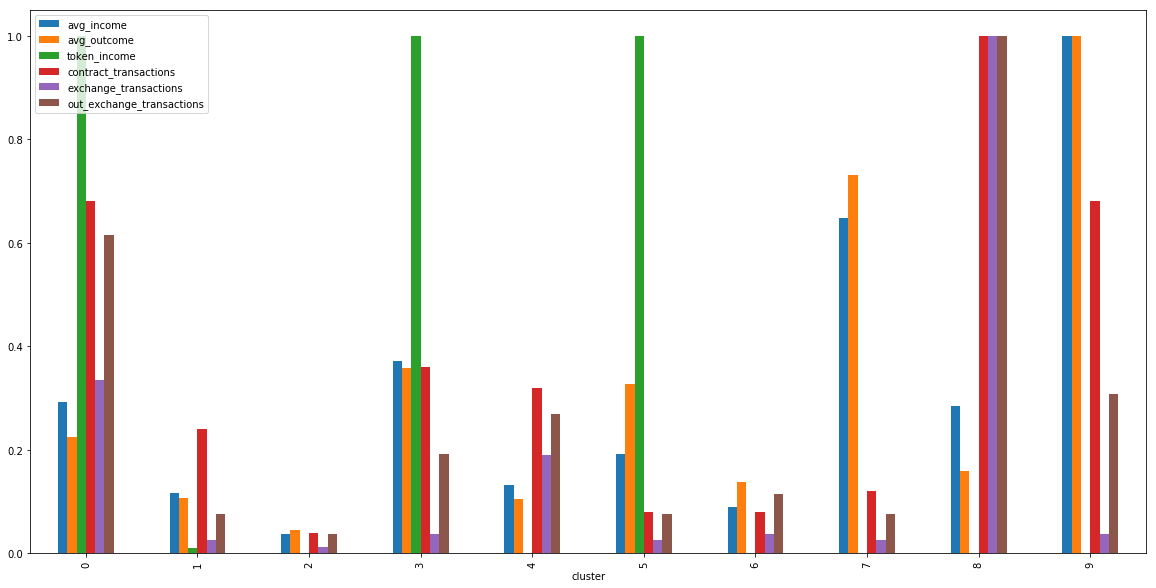

In [620]:
plt.figure()
(cleaned_addresses.groupby("cluster").median() / cleaned_addresses.groupby("cluster").median().max(axis=0)).plot(kind="bar", figsize=(20, 10))

## Viuly

In [3]:
drop_addresses = ["0x30146933a3a0babc74ec0b3403bec69281ba5914"]

In [7]:
cex_addresses = ['0x236f9f97e0e62388479bf9e5ba4889e46b0273c3',
 '0x2a0c0dbecc7e4d658f48e01e3fa353f44050c208',
 '0x6cc5f688a315f3dc28a7781717a9a798a59fda7b',
 '0x8d12a197cb00d4747a1fe03395095ce2a5cc6819']

In [8]:
transactions_df = pd.read_csv("viuly_airdrop.csv")

In [9]:
start_block = 5179745

In [31]:
AFTER_BLOCK_GAP = 200000
BEFORE_BLOCK_GAP = 100000
end_block = start_block + AFTER_BLOCK_GAP

In [32]:
transactions_df[(transactions_df["block_id"] > start_block - BEFORE_BLOCK_GAP) & (transactions_df["block_id"] < start_block + AFTER_BLOCK_GAP) & (transactions_df["from"] == "0x30146933a3a0babc74ec0b3403bec69281ba5914")].shape

(195, 15)

In [33]:
airdrop_transactions = transactions_df[(transactions_df["block_id"] > start_block - BEFORE_BLOCK_GAP) & (transactions_df["block_id"] < start_block + AFTER_BLOCK_GAP) & (transactions_df["from"] == "0x30146933a3a0babc74ec0b3403bec69281ba5914")]

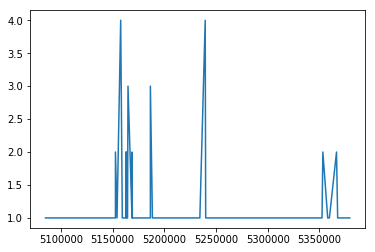

In [37]:
plt.plot(airdrop_transactions[["block_id", "tx_hash"]].groupby("block_id").count())

- Найти всех участников дропа
- Убрать биржи/дропы
- Кластеризовать по признакам (до дропа)
    - Средний вход eth
    - Средний выход eth
    - Количество имеющихся токенов на счете до дропа - (количество уникальных контрактов)
    - Количество и объем транзакций ICO (пока не трогать)
    - Количество обращений к контрактам (c ненулевым input)
    - Количество исходящих транзакций на биржи 
    - Количество входящих транзакций с бирж
- Агрегировать по кластерам
- Посмотреть, какие кластеры могут влиять на качество дропа

In [54]:
all_addresses = list(set(list(transactions_df["from"].unique()) + list(transactions_df["to"].unique())))[1:]

In [55]:
addresses_df = pd.DataFrame()
addresses_df["address"] = all_addresses
addresses_df = addresses_df.set_index('address')

In [56]:
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

In [61]:
def add_features(index, doc_type, query_lambda, key):
    result = []
    for addresses in tqdm_notebook(list(chunks(all_addresses, 1000))):
        query = query_lambda(addresses, key)
        result.append(client.search(index=index, doc_type=doc_type, query=query))

    results = {b["key"]: b[key]["value"] for r in result for b in r["aggregations"]["drops"]["buckets"]}
    for address, value in tqdm_notebook(results.items()):
        addresses_df.loc[address, key] = value

In [62]:
start_block

5179745

In [63]:
def query(addresses, key):
    query = {
        "size": 0,
        "query": {
            "bool": {
                "must": [
                    {"terms": {"to": addresses}},
                    {"range": {"blockNumber": {"lte": start_block}}}
                ]
            }
        },
        "aggs": {
            "drops": {
                "terms": {
                    "field": "to",
                    "size": len(addresses),
                },
                "aggs": {
                    key: {
                        "avg": {
                            "field": "value"
                        }
                    }
                }
            }
        }
    }
    return query

add_features(index="ethereum-internal-transaction", doc_type="itx", query_lambda=query, key="avg_income")

In [64]:
def query(addresses, key):
    query = {
        "size": 0,
        "query": {
            "bool": {
                "must": [
                    {"terms": {"from": addresses}},
                    {"range": {"blockNumber": {"lte": start_block}}}
                ]
            }
        },
        "aggs": {
            "drops": {
                "terms": {
                    "field": "from",
                    "size": len(addresses),
                },
                "aggs": {
                    key: {
                        "avg": {
                            "field": "value"
                        }
                    }
                }
            }
        }
    }
    return query

add_features(index="ethereum-internal-transaction", doc_type="itx", query_lambda=query, key="avg_outcome")

In [65]:
def query(addresses, key):
    query = {
        "size": 0,
        "query": {
            "bool": {
                "must": [
                    {"terms": {"to.keyword": addresses}},
                    {"term": {"token.keyword": TOKEN}},
                    {"range": {"block_id": {"lte": start_block}}}
                ]
            }
        },
        "aggs": {
            "drops": {
                "terms": {
                    "field": "to.keyword",
                    "size": len(addresses),
                },
                "aggs": {
                    key: {
                        "sum": {
                            "field": "value"
                        }
                    }
                }
            }
        }
    }
    return query

add_features(index="ethereum-token-transaction", doc_type="tx", query_lambda=query, key="token_income")

NameError: name 'TOKEN' is not defined

In [ ]:
def query(addresses, key):
    query = {
        "size": 0,
        "query": {
            "bool": {
                "must": [
                    {"terms": {"from": addresses}},
                    {"query_string": {"query": "!(input:0x)"}},
                    {"range": {"block_id": {"lte": start_block}}}
                ]
            }
        },
        "aggs": {
            "drops": {
                "terms": {
                    "field": "from",
                    "size": len(addresses),
                },
                "aggs": {
                    key: {
                        "cardinality": {
                            "field": "to"
                        }
                    }
                }
            }
        }
    }
    return query

add_features(index="ethereum-internal-transaction", doc_type="itx", query_lambda=query, key="contract_transactions")

In [ ]:
def query(addresses, key):
    query = {
        "size": 0,
        "query": {
            "bool": {
                "must": [
                    {"terms": {"from": addresses}},
                    {"terms": {"to": cex_addresses}},
                ]
            }
        },
        "aggs": {
            "drops": {
                "terms": {
                    "field": "from",
                    "size": len(addresses),
                },
                "aggs": {
                    key: {
                        "value_count": {
                            "field": "value"
                        }
                    }
                }
            }
        }
    }
    return query

add_features(index="ethereum-internal-transaction", doc_type="itx", query_lambda=query, key="exchange_transactions")

In [ ]:
def query(addresses, key):
    query = {
        "size": 0,
        "query": {
            "bool": {
                "must": [
                    {"terms": {"to": addresses}},
                    {"terms": {"from": cex_addresses}},
                ]
            }
        },
        "aggs": {
            "drops": {
                "terms": {
                    "field": "to",
                    "size": len(addresses),
                },
                "aggs": {
                    key: {
                        "value_count": {
                            "field": "value"
                        }
                    }
                }
            }
        }
    }
    return query

add_features(index="ethereum-internal-transaction", doc_type="itx", query_lambda=query, key="out_exchange_transactions")

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [ ]:
addresses_df.to_csv("addresses_stats2.csv")

In [613]:
addresses_df = pd.read_csv("addresses_stats2.csv").set_index("address")

In [597]:
for column in addresses_df.columns:
    addresses_df[column] = np.log(addresses_df[column].fillna(0) + 1 + 0.00001 * np.random.randn(addresses_df.shape[0]))

In [598]:
kmeans = KMeans(n_clusters=10)
clusters = kmeans.fit_predict(addresses_df)

In [615]:
addresses_df["cluster"] = clusters

In [600]:
pca = PCA(n_components=2)
pca_stats = pca.fit_transform(addresses_df)

In [601]:
from sklearn.manifold import TSNE
# pca_stats = TSNE(n_components=2, verbose=1).fit_transform(addresses_df)

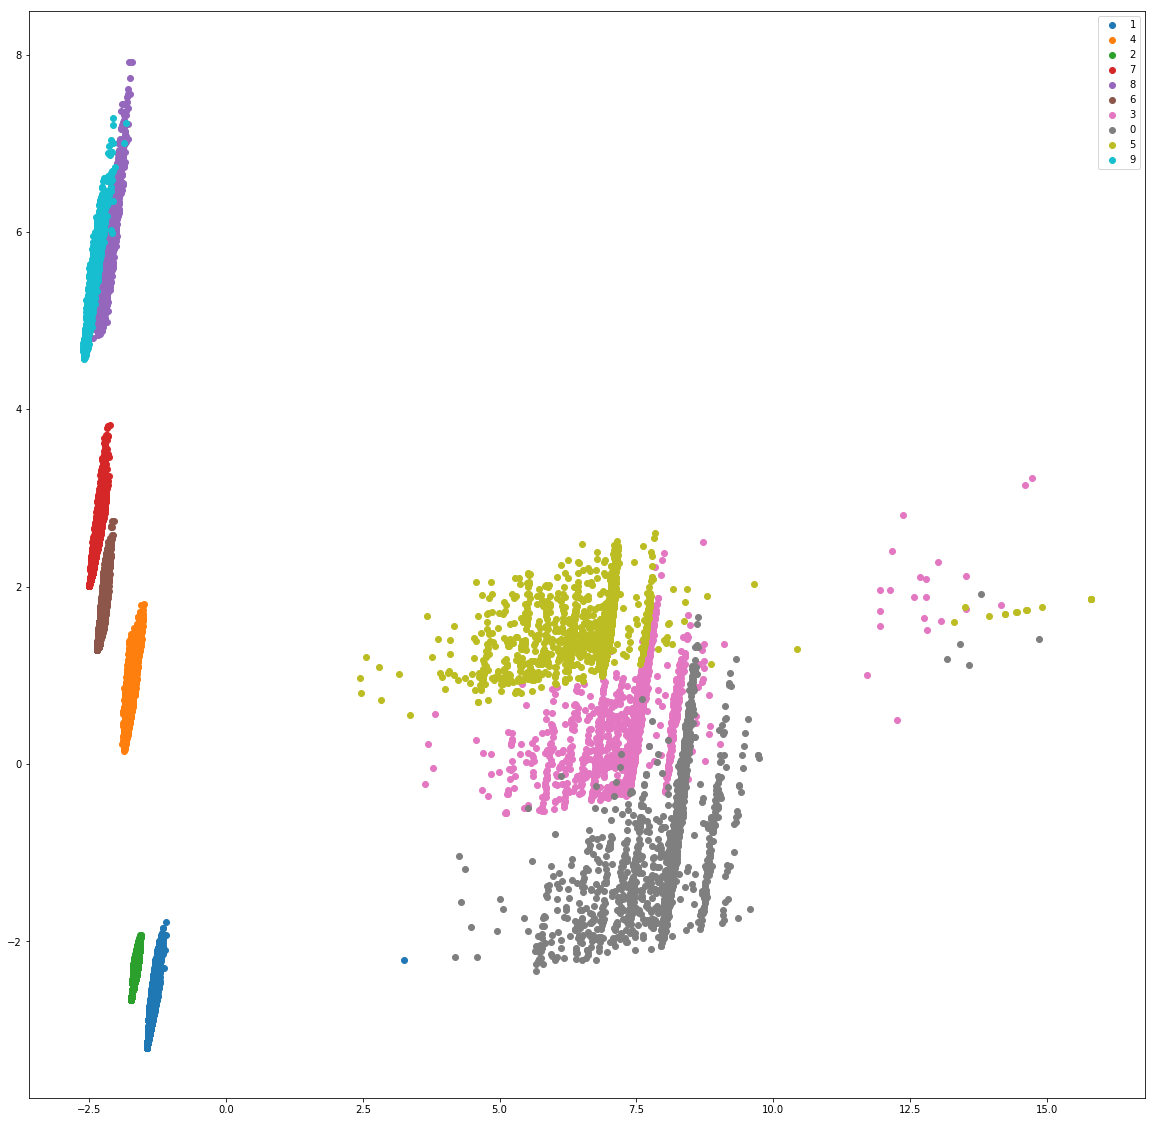

In [602]:
plt.figure(figsize=(20, 20))
for cluster in addresses_df["cluster"].unique():
    stats = pca_stats[addresses_df["cluster"] == cluster]
    plt.scatter(stats.transpose()[0], stats.transpose()[1], label=cluster)
plt.legend()

In [603]:
clusters = addresses_df["cluster"]

In [604]:
addresses_df["cluster"] = clusters

In [617]:
cleaned_addresses = addresses_df[~addresses_df.index.isin(cex_addresses + drop_addresses)]

In [618]:
cleaned_addresses.groupby("cluster").median()

,avg_income,avg_outcome,token_income,contract_transactions,exchange_transactions,out_exchange_transactions
cluster,,,,,,
0,1.522184,0.684226,10714.000000,17.0,26.5,16.0
1,0.611492,0.325489,107.139999,6.0,2.0,2.0
2,0.198234,0.138000,NaN,1.0,1.0,1.0
3,1.935696,1.093373,10714.000000,9.0,3.0,5.0
4,0.689281,0.319622,NaN,8.0,15.0,7.0
5,1.003000,0.998150,10714.000000,2.0,2.0,2.0
6,0.470000,0.423077,NaN,2.0,3.0,3.0
7,3.368182,2.233333,NaN,3.0,2.0,2.0
8,1.484388,0.488792,NaN,25.0,79.0,26.0


In [619]:
cleaned_addresses.groupby("cluster").median()

,avg_income,avg_outcome,token_income,contract_transactions,exchange_transactions,out_exchange_transactions
cluster,,,,,,
0,1.522184,0.684226,10714.000000,17.0,26.5,16.0
1,0.611492,0.325489,107.139999,6.0,2.0,2.0
2,0.198234,0.138000,NaN,1.0,1.0,1.0
3,1.935696,1.093373,10714.000000,9.0,3.0,5.0
4,0.689281,0.319622,NaN,8.0,15.0,7.0
5,1.003000,0.998150,10714.000000,2.0,2.0,2.0
6,0.470000,0.423077,NaN,2.0,3.0,3.0
7,3.368182,2.233333,NaN,3.0,2.0,2.0
8,1.484388,0.488792,NaN,25.0,79.0,26.0


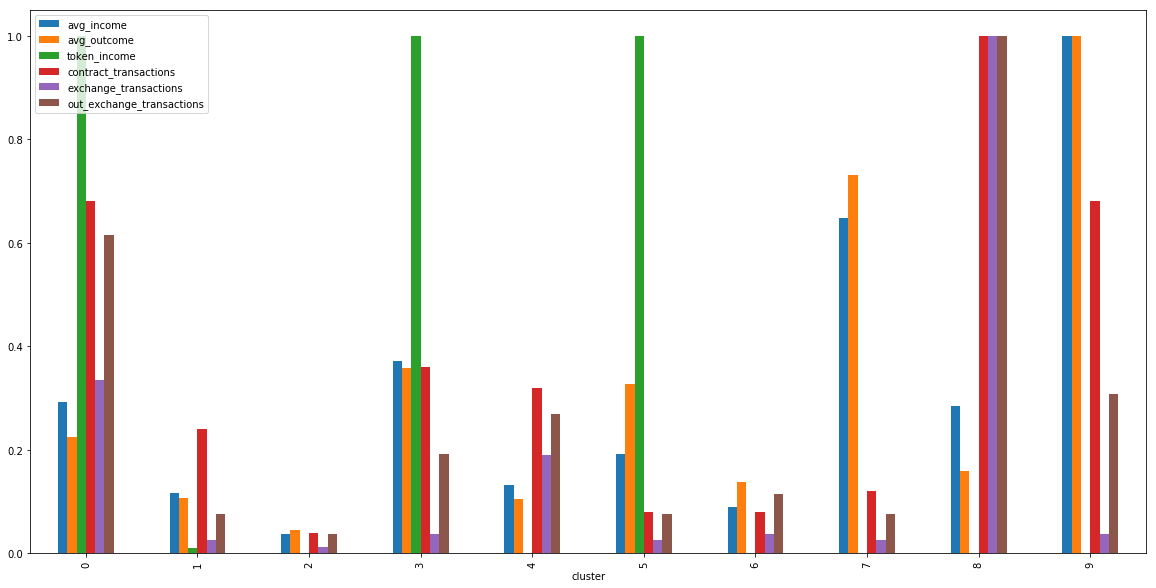

In [620]:
plt.figure()
(cleaned_addresses.groupby("cluster").median() / cleaned_addresses.groupby("cluster").median().max(axis=0)).plot(kind="bar", figsize=(20, 10))